In [1]:
import sys
sys.path.append('../src')

from module.module import Linear, Conv1D, MaxPool1D, Flatten
from module.activation import TanH, Sigmoide, ReLU, Softmax

from loss.loss import CELogSoftmax
from networks.optim import Optim
from networks.sequentiel import Sequentiel

from utils.processing import one_hot_y, normalisation
from utils.plots import plot_net, classification_report

import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from resizeimage import resizeimage
from scipy.ndimage import rotate

import os
from PIL import Image

from sklearn.manifold import TSNE


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def rotate_image(img, angle):
    return rotate(img, angle, reshape=False, cval=255)

In [55]:
def get_signatures(test=False, rotate=True):
    labels = {
        "PersonA": 0,
        "PersonB": 1,
        "PersonC": 2,
        "PersonD": 3,
        "PersonE": 4,
    }

    type_data = "Train"
    if test:
        type_data = "Test"

    folder_dir = f"../data/signature/{type_data}"

    X = []
    y = []

    new_size = (28, 28)

    for person in os.listdir(folder_dir):
        for path in os.listdir(f"{folder_dir}/{person}"):
            img = Image.open(f"{folder_dir}/{person}/{path}")
            img = np.array(resizeimage.resize_contain(img, [75, 75]))[
                :, :, 0:3
            ].reshape(-1, 3)

            X.append(img)
            y.append(labels[person])

            if rotate:
                for angle in [90, 180, 270, 45, 135, 225, 315]:
                    img_r = rotate_image(img.reshape(75, 75, 3), angle).reshape(-1, 3)
                    X.append(img_r)
                    y.append(labels[person])

    X = np.array(X)
    y = np.array(y)

    indices = np.random.permutation(len(X))
    return X[indices], y[indices]

In [56]:
X_train, y_train = get_signatures()

In [57]:
X_train = normalisation(X_train)
X_train.shape

(1600, 5625, 3)

In [58]:
X_test, y_test = get_signatures(test=True)
X_test = normalisation(X_test)
X_test.shape

(320, 5625, 3)

In [7]:
classes = len(np.unique(y_train))
classes

5

In [8]:
y_one_hot = one_hot_y(y_train, classes)
y_one_hot.shape

(1600, 5)

In [9]:
st0 = np.random.get_state()

100%|██████████| 100/100 [43:56<00:00, 26.37s/it]

Training completed.


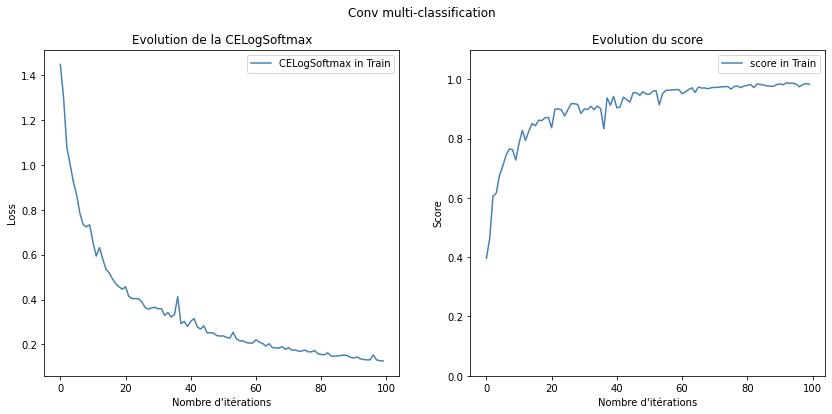

In [10]:
net = Sequentiel([
    Conv1D(k_size=2, chan_in=3, chan_out=16, stride=3, init="xavier"),
    MaxPool1D(2, 3), 
    Flatten(),
    Linear(10_000, 100, init="xavier"),
    ReLU(),
    Linear(100, 5, init="xavier"),
], classes_type="multi")

optim = Optim(net, CELogSoftmax(), eps=1e-5)
optim.SGD(X_train, y_one_hot, test_train_split=False, batch_size=10, epochs=100, verbose=False)

plot_net(optim, X_train, y_one_hot, net_type="multiclass", net_title="Conv multi-classification")

In [11]:
net.score(X_test, y_test)

0.871875

In [12]:
net.score(X_train, y_train)

0.983125

In [13]:
yhat = net.predict(X_test).reshape(-1)

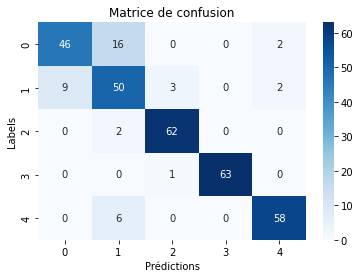

In [14]:
df = classification_report(y_test, yhat, [f"{i}" for i in range(5)])

In [15]:
print(df.to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrllr}
\toprule
{} &  precision & recall & f1-score &  support \\
class    &            &        &          &          \\
\midrule
0        &       0.84 &   0.72 &     0.77 &       64 \\
1        &       0.68 &   0.78 &     0.72 &       64 \\
2        &       0.94 &   0.97 &     0.95 &       64 \\
3        &       1.00 &   0.98 &     0.99 &       64 \\
4        &       0.94 &   0.91 &     0.92 &       64 \\
accuracy &       0.87 &        &          &      320 \\
\bottomrule
\end{tabular}



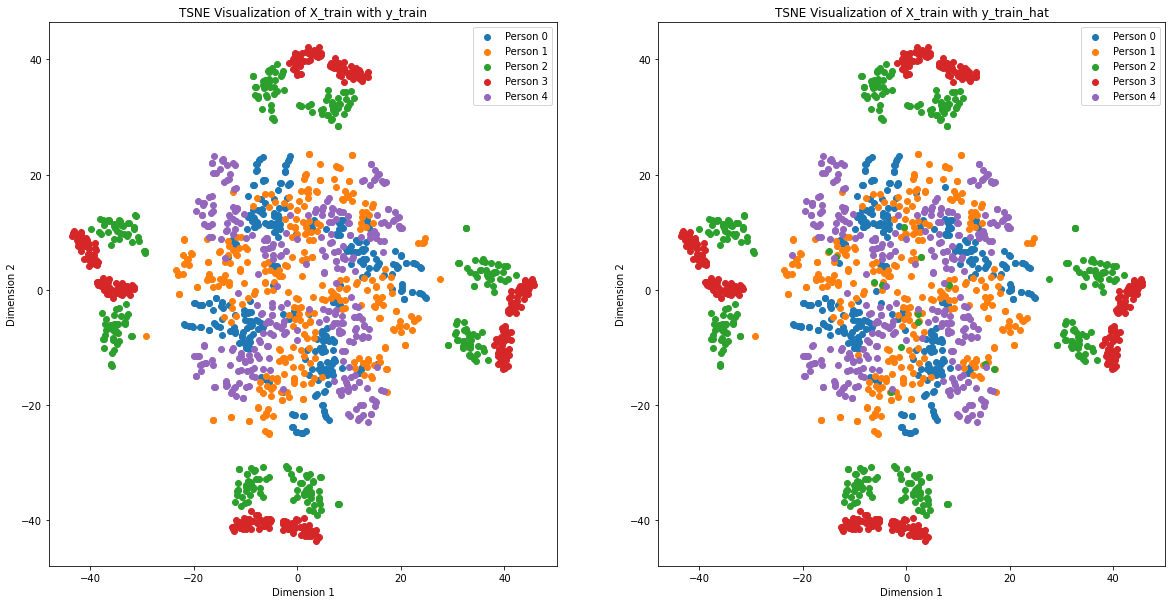

In [16]:
aff = TSNE(n_components=2, random_state=0, init="pca", n_iter=500, verbose=0)
sign_aff = aff.fit_transform(X_train.reshape(len(X_train), -1))

colors = {i: plt.cm.tab10(i) for i in range(classes)}

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].set_title("TSNE Visualization of X_train with y_train")

for cl in range(classes):
    axs[0].scatter(sign_aff[y_train == cl][:, 0], sign_aff[y_train == cl][:, 1], color=colors[cl], label=f"Person {cl}")
    
axs[0].set_xlabel("Dimension 1")
axs[0].set_ylabel("Dimension 2")
axs[0].legend()

y_train_hat = net.predict(X_train).reshape(-1)

axs[1].set_title("TSNE Visualization of X_train with y_train_hat")
for cl in range(classes):
    axs[1].scatter(sign_aff[y_train_hat == cl][:, 0], sign_aff[y_train_hat == cl][:, 1], color=colors[cl], label=f"Person {cl}")
    
axs[1].set_xlabel("Dimension 1")
axs[1].set_ylabel("Dimension 2")
axs[1].legend()

plt.show()

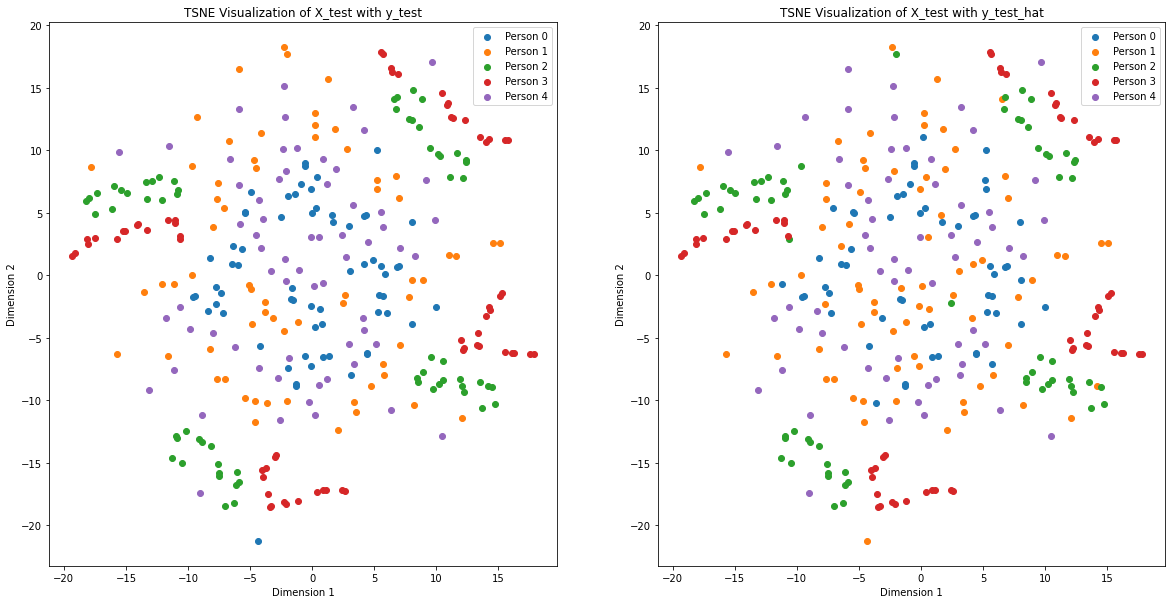

In [17]:
aff = TSNE(n_components=2, random_state=0, init="pca", n_iter=500, verbose=0)
sign_aff = aff.fit_transform(X_test.reshape(len(X_test), -1))

colors = {i: plt.cm.tab10(i) for i in range(classes)}

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].set_title("TSNE Visualization of X_test with y_test")

for cl in range(classes):
    axs[0].scatter(sign_aff[y_test == cl][:, 0], sign_aff[y_test == cl][:, 1], color=colors[cl], label=f"Person {cl}")
    
axs[0].set_xlabel("Dimension 1")
axs[0].set_ylabel("Dimension 2")
axs[0].legend()

y_test_hat = net.predict(X_test).reshape(-1)

axs[1].set_title("TSNE Visualization of X_test with y_test_hat")
for cl in range(classes):
    axs[1].scatter(sign_aff[y_test_hat == cl][:, 0], sign_aff[y_test_hat == cl][:, 1], color=colors[cl], label=f"Person {cl}")
    
axs[1].set_xlabel("Dimension 1")
axs[1].set_ylabel("Dimension 2")
axs[1].legend()

plt.show()